<a href="https://colab.research.google.com/github/Shuvam1024/compsr/blob/main/ShuvamSR50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional autoencoder for image denoising

**Author:** [Shuvam Mukherjee](shuvam1024@gmail.com)<br>
**Date created:** 2021/08/01<br>
**Last modified:** 2021/08/01<br>
**Description:** Train a deep convolutional network for joint compression artifact removal and super-resolution.

## Introduction

This example demonstrates how to implement a deep convolutional network
for joint image compression noise mitigation, and super-resolution.

## Setup

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow import pad


def preprocess(array, patchsize):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), patchsize, patchsize, 1))
    return array

def get_mse(x, y):
    """
    Gets mse of two tensors of size [batchize, height, width]
    """
    mse = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
    return mse(x, y).numpy()


def display(array1, array2, patchsize):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


def display3(array1, array2, array3, patchsize):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    images3 = array3[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image1.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(image3.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Prepare the data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ls gdrive/"My Drive"/"Colab Notebooks"
patchsize = 40

Mounted at /content/gdrive
 california_housing_test.csv	   DIV2K_valid_2by1_50_64x64.test
 california_housing_train.csv	  'Making the Most of your Colab Subscription'
 DIV2K_train_2by1_20_40x40.train   model_2by1_q30.keras
 DIV2K_train_2by1_20_40x40.valid   model_2by1_q40.keras
 DIV2K_train_2by1_30_40x40.train   model_2by1_q50.keras
 DIV2K_train_2by1_30_40x40.valid   model_2by1_q50s.keras
 DIV2K_train_2by1_40_40x40.train  'Shuvam MyTest0.ipynb'
 DIV2K_train_2by1_40_40x40.valid  'Shuvam MyTest2.ipynb'
 DIV2K_train_2by1_50_40x40.train   ShuvamSR30.ipynb
 DIV2K_train_2by1_50_40x40.valid   ShuvamSR40.ipynb
 DIV2K_valid_2by1_20_64x64.test    ShuvamSR50.ipynb
 DIV2K_valid_2by1_30_64x64.test    ShuvamSR50s.ipynb
 DIV2K_valid_2by1_40_64x64.test    ShuvamSR.ipynb


In [ ]:
x = np.fromfile('gdrive/My Drive/Colab Notebooks/DIV2K_train_2by1_50_40x40.train', dtype=np.uint8).reshape(-1, 2, patchsize, patchsize)
train_data=x[:, 0, :, :]
noisy_train_data=x[:, 1, :, :]

# Normalize and reshape the data
train_data = preprocess(train_data, patchsize)
noisy_train_data = preprocess(noisy_train_data, patchsize)

In [ ]:
x = np.fromfile('gdrive/My Drive/Colab Notebooks/DIV2K_train_2by1_50_40x40.valid', dtype=np.uint8).reshape(-1, 2, patchsize, patchsize)
valid_data=x[:, 0, :, :]
noisy_valid_data=x[:, 1, :, :]

# Normalize and reshape the data
valid_data = preprocess(valid_data, patchsize)
noisy_valid_data = preprocess(noisy_valid_data, patchsize)

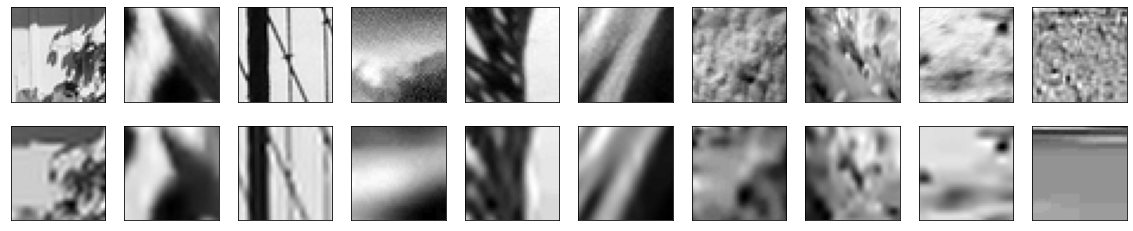

In [ ]:
# Display the train data and a version of it with added noise
display(train_data, noisy_train_data, patchsize)

In [ ]:
loss_noisy_train = get_mse(train_data, noisy_train_data)
print('Training Noisy MSE: ' + str(loss_noisy_train))
loss_noisy_valid = get_mse(valid_data, noisy_valid_data)
print('Validation Noisy MSE: ' + str(loss_noisy_valid))

Training Noisy MSE: 0.001433897
Validation Noisy MSE: 0.0016234531


## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

In [ ]:
'''
  2D Replication Padding
  Attributes:
    - padding: (padding_width, padding_height) tuple
'''
class ReplicationPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReplicationPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + 2 * self.padding[0], input_shape[2] + 2 * self.padding[1], input_shape[3])

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        return pad(input_tensor, [[0,0], [padding_height, padding_height], [padding_width, padding_width], [0,0] ], 'SYMMETRIC')


input = layers.Input(shape=(None, None, 1))

# Encoder
# x = ReplicationPadding2D(padding=(1, 1))(input)

x = layers.Conv2D(32, (5, 5), activation="relu", strides=(2, 2), padding="same")(input)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2D(24, (3, 3), activation="relu", padding="same")(x)

# Decoder
x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
# x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="tanh", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="mean_squared_error", metrics=['mse'])
autoencoder.summary()

Now we can train our autoencoder using `train_data` as both our input data
and target. Notice we are setting up the validation data using the same
format.

In [ ]:
#autoencoder.fit(
#    x=train_data,
#    y=train_data,
#    epochs=50,
#    batch_size=128,
#    shuffle=True,
#    validation_data=(test_data, test_data),
#)

Let's predict on our test dataset and display the original image together with
the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although
not quite the same.

In [ ]:
#predictions = autoencoder.predict(valid_data)
#display(valid_data, predictions)

Now that we know that our autoencoder works, let's retrain it using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=25,
    batch_size=256,
    shuffle=True,
    validation_data=(noisy_valid_data, valid_data),
)
autoencoder.save('gdrive/My Drive/Colab Notebooks/model_2by1_q50.keras')

Epoch 1/25
1090/1090 [==============================] - 17s 15ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 2/25
1090/1090 [==============================] - 16s 15ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 3/25
1090/1090 [==============================] - 16s 15ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 4/25
1090/1090 [==============================] - 16s 15ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 5/25
1090/1090 [==============================] - 16s 15ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 6/25
1090/1090 [==============================] - 16s 15ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 7/25
1090/1090 [==============================] - 16s 15ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 8/25
1090/1090 [==========================

Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.

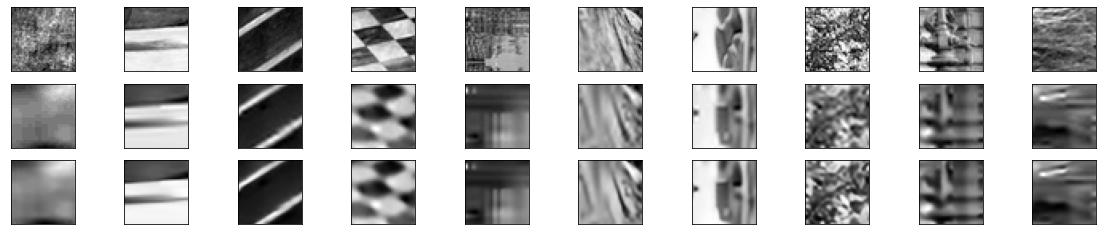

Valid Restored MSE: 0.0014872574
Valid MSE Reduction %: 8.38925912976265


In [ ]:
autoencoder = tf.keras.models.load_model('gdrive/My Drive/Colab Notebooks/model_2by1_q50.keras')

restored_valid_data = autoencoder.predict(noisy_valid_data)
display3(valid_data, noisy_valid_data, restored_valid_data, patchsize)

loss_restored_valid = get_mse(valid_data, restored_valid_data)
print('Valid Restored MSE: ' + str(loss_restored_valid))
valid_loss_pct = (loss_noisy_valid - loss_restored_valid) / loss_noisy_valid * 100
print('Valid MSE Reduction %: ' + str(valid_loss_pct))

Load the noisy test data and restore it.

In [ ]:
autoencoder = tf.keras.models.load_model('gdrive/My Drive/Colab Notebooks/model_2by1_q50.keras')

testpatchsize = 64
x = np.fromfile('gdrive/My Drive/Colab Notebooks/DIV2K_valid_2by1_50_64x64.test', dtype=np.uint8).reshape(-1, 2, testpatchsize, testpatchsize)
test_data=x[:, 0, :, :]
noisy_test_data=x[:, 1, :, :]

# Normalize and reshape the data
test_data = preprocess(test_data, testpatchsize)
noisy_test_data = preprocess(noisy_test_data, testpatchsize)
loss_noisy_test = get_mse(test_data, noisy_test_data)
print('Test Noisy MSE: ' + str(loss_noisy_test))

restored_test_data = autoencoder.predict(noisy_test_data)
loss_restored_test = get_mse(test_data, restored_test_data)
print('Test Restored MSE: ' + str(loss_restored_test))

test_loss_pct = (loss_noisy_test - loss_restored_test) / loss_noisy_test * 100
print('Test MSE Reduction %: ' + str(test_loss_pct))

Test Noisy MSE: 0.001419291
Test Restored MSE: 0.0012725041
Test MSE Reduction %: 10.342270135879517
